### Notebook Purpose
*This notebook imports 'CCMF Race Relations Taxonomy' Google Sheet, 'CCMF Locations Edited' sheet, and uses available data to add latitude / longitude values of each incident, in order to facilitate mapping / plotting*

In [1]:
import pandas as pd

In [2]:
ccmf = pd.read_csv('E:/Datasets/CCMF_Locations_Edited.csv',
                   index_col = 'incident_id')

In [3]:
ccmf.head(3)

,location,province,national
incident_id,,,
1,Burnaby,British Columbia,NaN
2,Windsor,Ontario,NaN
3,Ottawa,Ontario,NaN


In [4]:
ccmf['location'] = ccmf['location'].str.title()
ccmf.head(3)

,location,province,national
incident_id,,,
1,Burnaby,British Columbia,NaN
2,Windsor,Ontario,NaN
3,Ottawa,Ontario,NaN


In [5]:
ccmf['province'].describe()

count         955
unique         14
top       Ontario
freq          361
Name: province, dtype: object

In [6]:
ccmf['province'].value_counts()

Ontario                  361
British Columbia         153
Alberta                  132
Quebec                   130
Nova Scotia               64
Manitoba                  49
Saskatchewan              28
Newfoundland Labrador     15
New Brunswick             10
Prince Edward Island       5
Unknown                    3
Nunavut                    2
Northwest Territories      2
Yukon                      1
Name: province, dtype: int64

In [7]:
# Set up provinces and territories long and short names to help with data preparation
# notice that Newfoundlance and Labrador has some values as Newfoundland Labrador
prov_long = ['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 
             'Newfoundland Labrador', 'Nova Scotia', 'Northwest Territories', 'Nunavut', 'Ontario',
             'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon']
prov_short = ['AB', 'BC', 'MB', 'NB', 'NL', 'NL', 'NS', 'NT', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT']

In [8]:
#replace NA values, and `national` values with NA in location column

ccmf['loc_city'] = ['NA' if x in ['national', 'National', 'NA', 'Canada'] else x for x in ccmf['location']]

# if location is a province, then change location city to NA, and have the province value only once

ccmf['loc_city'] = ['NA' if x in prov_long else x for x in ccmf['loc_city']]
ccmf['loc_city'] = ['NA' if x in prov_short else x for x in ccmf['loc_city']]


#make sure that province value is the correct province if location is province not city

ccmf['province'] = ['NA' if x in ['national', 'National', 'NA', 'Canada', 'Unknown']
                   else x for x in ccmf['province']]
ccmf['province'] = [x if x in prov_long else y for x, y in zip(ccmf['location'], ccmf['province'])]
ccmf['province'] = [x if x in prov_short else y for x, y in zip(ccmf['location'], ccmf['province'])]
#ccmf['location_2'].value_counts()

# change province column to short version of the name to maintain consistency
for x, y in zip(prov_short, prov_long):
    ccmf['province'] = ccmf['province'].str.replace(y, x, regex = True)

In [9]:
ccmf.head(8)

,location,province,national,loc_city
incident_id,,,,
1,Burnaby,BC,NaN,Burnaby
2,Windsor,ON,NaN,Windsor
3,Ottawa,ON,NaN,Ottawa
4,Calgary,AB,NaN,Calgary
5,Tignish,PE,NaN,Tignish
6,NaN,NB,NaN,NaN
7,Toronto,ON,NaN,Toronto
8,NaN,NS,NaN,NaN


In [10]:
#replace  NA values, and `national` values with NA in province column
ccmf['loc_province'] = ['Canada' if x in ['NA', 'National'] else (str(x) + ', Canada') for x in ccmf['province']]
ccmf.head()

,location,province,national,loc_city,loc_province
incident_id,,,,,
1,Burnaby,BC,NaN,Burnaby,"BC, Canada"
2,Windsor,ON,NaN,Windsor,"ON, Canada"
3,Ottawa,ON,NaN,Ottawa,"ON, Canada"
4,Calgary,AB,NaN,Calgary,"AB, Canada"
5,Tignish,PE,NaN,Tignish,"PE, Canada"


In [11]:
#Concatenate loc_city, and loc_province columns to have a complete location value of
# city, province, Canada | province, Canada, or Canada
ccmf['complete_loc'] = [y if x == 'NA' else (str(x) + ', ' + y) for x, y in zip(ccmf['loc_city'], ccmf['loc_province'])]

In [12]:
ccmf.head(3)

,location,province,national,loc_city,loc_province,complete_loc
incident_id,,,,,,
1,Burnaby,BC,NaN,Burnaby,"BC, Canada","Burnaby, BC, Canada"
2,Windsor,ON,NaN,Windsor,"ON, Canada","Windsor, ON, Canada"
3,Ottawa,ON,NaN,Ottawa,"ON, Canada","Ottawa, ON, Canada"


In [13]:
from geopy import Nominatim
locator = Nominatim(user_agent='myGeocoder')
from geopy.extra.rate_limiter import RateLimiter

In [14]:
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# 2- - create location column
ccmf['loc'] = ccmf['complete_loc'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
ccmf['point'] = ccmf['loc'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
ccmf[['latitude', 'longitude', 'altitude']] = pd.DataFrame(ccmf['point'].tolist(), index=ccmf.index)

ccmf.head()

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Regina, SK, Canada',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moha\Anaconda3\lib\urllib\request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "C:\Users\Moha\Anaconda3\lib\http\client.py", line 1229, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "C:\Users\Moha\Anaconda3\lib\http\client.py", line 1275, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "C:\Users\Moha\Anaconda3\lib\http\client.py", line 1224, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "C:\Users\Moha\Anaconda3\lib\http\client.py", line 1016, in _send_output
    self.send(msg)
  File "C:\Users\Moha\Anaconda3\lib\http\client.py", line 956, in send
    self.connect()
  File "C:\Users\Moha\Anaconda3\lib\http\client.py", line 1392, in connect
    server_hostname=server_hostname)
  File "

,location,province,national,loc_city,loc_province,complete_loc,loc,point,latitude,longitude,altitude
incident_id,,,,,,,,,,,
1,Burnaby,BC,NaN,Burnaby,"BC, Canada","Burnaby, BC, Canada","(Burnaby, Metro Vancouver Regional District, B...","(49.2433804, -122.9725459, 0.0)",49.243380,-122.972546,0.0
2,Windsor,ON,NaN,Windsor,"ON, Canada","Windsor, ON, Canada","(Windsor, Southwestern Ontario, Ontario, N9A 3...","(42.317099, -83.0353434, 0.0)",42.317099,-83.035343,0.0
3,Ottawa,ON,NaN,Ottawa,"ON, Canada","Ottawa, ON, Canada","(Ottawa, Eastern Ontario, Ontario, K1P 1J1, Ca...","(45.421106, -75.690308, 0.0)",45.421106,-75.690308,0.0
4,Calgary,AB,NaN,Calgary,"AB, Canada","Calgary, AB, Canada","(Calgary, Alberta, Canada, (51.0534234, -114.0...","(51.0534234, -114.0625892, 0.0)",51.053423,-114.062589,0.0
5,Tignish,PE,NaN,Tignish,"PE, Canada","Tignish, PE, Canada","(Little Tignish River, Prince County, Prince E...","(46.9189808, -64.039147, 0.0)",46.918981,-64.039147,0.0


In [15]:
#After lat and long data are retrieved for each location, count no of locations where no lat-long data was retrieved

print(ccmf['latitude'].isna().sum())
print(ccmf['longitude'].isna().sum())

9
9


In [16]:
#create a new dataframe for locations where no lat-long data was retrieved

ccmf_rev = ccmf[ccmf['latitude'].isna()].copy()
ccmf_rev[['location', 'province', 'loc_city', 'complete_loc', 'latitude', 'longitude']]

,location,province,loc_city,complete_loc,latitude,longitude
incident_id,,,,,,
137,Enerby,BC,Enerby,"Enerby, BC, Canada",NaN,NaN
160,Village Of Perdue,SK,Village Of Perdue,"Village Of Perdue, SK, Canada",NaN,NaN
165,Statford,ON,Statford,"Statford, ON, Canada",NaN,NaN
170,Statford,ON,Statford,"Statford, ON, Canada",NaN,NaN
185,Keeseekoowenin Ojibway First Nation,MB,Keeseekoowenin Ojibway First Nation,"Keeseekoowenin Ojibway First Nation, MB, Canada",NaN,NaN
191,Nova Scotia'S Pictou County,NS,Nova Scotia'S Pictou County,"Nova Scotia'S Pictou County, NS, Canada",NaN,NaN
339,Mount Polley,QC,Mount Polley,"Mount Polley, QC, Canada",NaN,NaN
805,Wet’Suwet’En,QC,Wet’Suwet’En,"Wet’Suwet’En, QC, Canada",NaN,NaN
880,Wet’Suwet’En,QC,Wet’Suwet’En,"Wet’Suwet’En, QC, Canada",NaN,NaN


### Start fixing location data one by one

In [17]:
#incident_id: 137, city name is Enderby not "Enerby", confirmed from article, correct name
ccmf_rev.loc[137,['location']] = 'Enderby'

#incident_id: 160, just use 'Perdue', and remove 'Village of'
ccmf_rev.loc[160,['location']] = 'Perdue'

#incident_id: 165, 170: city name is Stratford not 'Statford', confirmed from article, correct name
ccmf_rev.loc[[165, 170],['location']] = 'Stratford'
#ccmf_rev.loc[170,['location']] = 'Stratford'

#incident_id: 185 Keeseekoowenin Ojibway First Nation is located near Elphinstone, MB, change location accordingly
ccmf_rev.loc[185,['location']] = 'Elphinstone'

#incident_id: 191, remove Nova Scotia, and keep Pictou County only
ccmf_rev.loc[191,['location']] = 'Pictou County'

#incident_id: 339, Mount Polley is in BC not QC, confirmed from article, correct province
ccmf_rev.loc[339,['province']] = 'BC'

#incident_id: 805, and 880, location is Wet’suwet’en, could have changed due to encoding ??
#province is British Columbia, confirmed from articles
ccmf_rev.loc[[805, 880],['location']] = 'Wet’suwet’en'
ccmf_rev.loc[[805, 880],['province']] = 'BC'

ccmf_rev[['location', 'province', 'loc_city', 'complete_loc', 'latitude', 'longitude']]

,location,province,loc_city,complete_loc,latitude,longitude
incident_id,,,,,,
137,Enderby,BC,Enerby,"Enerby, BC, Canada",NaN,NaN
160,Perdue,SK,Village Of Perdue,"Village Of Perdue, SK, Canada",NaN,NaN
165,Stratford,ON,Statford,"Statford, ON, Canada",NaN,NaN
170,Stratford,ON,Statford,"Statford, ON, Canada",NaN,NaN
185,Elphinstone,MB,Keeseekoowenin Ojibway First Nation,"Keeseekoowenin Ojibway First Nation, MB, Canada",NaN,NaN
191,Pictou County,NS,Nova Scotia'S Pictou County,"Nova Scotia'S Pictou County, NS, Canada",NaN,NaN
339,Mount Polley,BC,Mount Polley,"Mount Polley, QC, Canada",NaN,NaN
805,Wet’suwet’en,BC,Wet’Suwet’En,"Wet’Suwet’En, QC, Canada",NaN,NaN
880,Wet’suwet’en,BC,Wet’Suwet’En,"Wet’Suwet’En, QC, Canada",NaN,NaN


### Redo same steps as above to prepare data of ccmf_rev dataframe

In [18]:
# if location is a province, then change location city to NA, and have the province value only once

ccmf_rev['loc_city'] = ['NA' if x in prov_long else x for x in ccmf_rev['location']]
ccmf_rev['loc_city'] = ['NA' if x in prov_short else x for x in ccmf_rev['loc_city']]

#replace  NA values, and `national` values with NA in province column
ccmf_rev['loc_province'] = ['Canada' if x == 'NA' else (str(x) + ', Canada') for x in ccmf_rev['province']]

#Concatenate location 3, and location 4 columns to have a complete location value of
# city, province, Canada | province, Canada, or Canada
ccmf_rev['complete_loc'] = [y if x == 'NA' else (str(x) + ', ' + y) for x, y in zip(ccmf_rev['loc_city'], ccmf_rev['loc_province'])]

ccmf_rev.head(3)

,location,province,national,loc_city,loc_province,complete_loc,loc,point,latitude,longitude,altitude
incident_id,,,,,,,,,,,
137,Enderby,BC,NaN,Enderby,"BC, Canada","Enderby, BC, Canada",None,None,NaN,NaN,NaN
160,Perdue,SK,NaN,Perdue,"SK, Canada","Perdue, SK, Canada",None,None,NaN,NaN,NaN
165,Stratford,ON,NaN,Stratford,"ON, Canada","Stratford, ON, Canada",None,None,NaN,NaN,NaN


In [19]:
# 2- - create location column
ccmf_rev['loc'] = ccmf_rev['complete_loc'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
ccmf_rev['point'] = ccmf_rev['loc'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
ccmf_rev[['latitude', 'longitude', 'altitude']] = pd.DataFrame(ccmf_rev['point'].tolist(), index=ccmf_rev.index)

ccmf_rev[['location', 'province', 'loc_city', 'complete_loc', 'latitude', 'longitude']]

,location,province,loc_city,complete_loc,latitude,longitude
incident_id,,,,,,
137,Enderby,BC,Enderby,"Enderby, BC, Canada",50.550479,-119.139779
160,Perdue,SK,Perdue,"Perdue, SK, Canada",52.056154,-107.544795
165,Stratford,ON,Stratford,"Stratford, ON, Canada",43.370090,-80.981802
170,Stratford,ON,Stratford,"Stratford, ON, Canada",43.370090,-80.981802
185,Elphinstone,MB,Elphinstone,"Elphinstone, MB, Canada",50.530346,-100.328254
191,Pictou County,NS,Pictou County,"Pictou County, NS, Canada",45.585537,-62.728322
339,Mount Polley,BC,Mount Polley,"Mount Polley, BC, Canada",50.717645,-121.918644
805,Wet’suwet’en,BC,Wet’suwet’en,"Wet’suwet’en, BC, Canada",54.023419,-126.675346
880,Wet’suwet’en,BC,Wet’suwet’en,"Wet’suwet’en, BC, Canada",54.023419,-126.675346


In [20]:
#Now update original dataframe with corrected value from revised dataframe
ccmf.update(ccmf_rev)
print(ccmf['latitude'].isna().sum())
ccmf[['location', 'province', 'loc_city', 'complete_loc', 'latitude', 'longitude']][45:55]

0


,location,province,loc_city,complete_loc,latitude,longitude
incident_id,,,,,,
46,Winnipeg,MB,Winnipeg,"Winnipeg, MB, Canada",49.895537,-97.138458
47,Toronto,ON,Toronto,"Toronto, ON, Canada",43.653482,-79.383935
48,Ottawa,ON,Ottawa,"Ottawa, ON, Canada",45.421106,-75.690308
49,Vaughan,ON,Vaughan,"Vaughan, ON, Canada",43.794154,-79.526802
50,NaN,PE,NaN,"nan, PE, Canada",46.335551,-63.146668
51,Regina,SK,Regina,"Regina, SK, Canada",50.448760,-104.617310
52,Ottawa,ON,Ottawa,"Ottawa, ON, Canada",45.421106,-75.690308
53,Ottawa,ON,Ottawa,"Ottawa, ON, Canada",45.421106,-75.690308
54,Halifax,NS,Halifax,"Halifax, NS, Canada",44.648618,-63.585949


In [21]:
ccmf = ccmf.drop(['loc', 'point'], axis = 1)

In [22]:
#import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster

In [23]:
map1 = folium.Map(
    location=[47,-73],
    tiles='cartodbpositron',
    zoom_start=1,
)


In [24]:
ccmf.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
map1

### Maps shoes all values are in Canada, which is a positive initial check

In [25]:
#Compare values of lat - long to values produced by Jeremy
cities = pd.read_csv('E:/Datasets/citiesList.csv')
cities.head()

,name,country.etc,pop,lat,long,capital
0,Abbotsford BC,BC,157795,49.06,-122.30,0
1,Acton ON,ON,8308,43.63,-80.03,0
2,Acton Vale QC,QC,5153,45.63,-72.57,0
3,Airdrie AB,AB,25863,51.30,-114.02,0
4,Aklavik NT,NT,643,68.22,-135.00,0


In [26]:
cities = cities.rename(columns={"name": "city", "country.etc": "province"})
cities.head()

,city,province,pop,lat,long,capital
0,Abbotsford BC,BC,157795,49.06,-122.30,0
1,Acton ON,ON,8308,43.63,-80.03,0
2,Acton Vale QC,QC,5153,45.63,-72.57,0
3,Airdrie AB,AB,25863,51.30,-114.02,0
4,Aklavik NT,NT,643,68.22,-135.00,0


In [27]:
#Remove province notation from city name as province has its own column
cities['city'] = cities['city'].str[:-3]
cities.head()

,city,province,pop,lat,long,capital
0,Abbotsford,BC,157795,49.06,-122.30,0
1,Acton,ON,8308,43.63,-80.03,0
2,Acton Vale,QC,5153,45.63,-72.57,0
3,Airdrie,AB,25863,51.30,-114.02,0
4,Aklavik,NT,643,68.22,-135.00,0


In [28]:
ccmf.drop(['altitude'], inplace = True, axis = 1)

In [29]:
#Capitalize first letter of city column to make sure merging dataframes works without issues
cities['city'] = cities['city'].str.title()
ccmf['loc_city'] = ccmf['loc_city'].str.title()
cities.head()

,city,province,pop,lat,long,capital
0,Abbotsford,BC,157795,49.06,-122.30,0
1,Acton,ON,8308,43.63,-80.03,0
2,Acton Vale,QC,5153,45.63,-72.57,0
3,Airdrie,AB,25863,51.30,-114.02,0
4,Aklavik,NT,643,68.22,-135.00,0


In [30]:
#join population, lat, and long data from cities dataframe to ccmf dataframe
ccmf_2 = ccmf.merge(cities, how = 'left', left_on = ['loc_city', 'province'], right_on = ['city', 'province'])
ccmf_2.head()

,location,province,national,loc_city,loc_province,complete_loc,latitude,longitude,city,pop,lat,long,capital
0,Burnaby,BC,NaN,Burnaby,"BC, Canada","Burnaby, BC, Canada",49.243380,-122.972546,NaN,NaN,NaN,NaN,NaN
1,Windsor,ON,NaN,Windsor,"ON, Canada","Windsor, ON, Canada",42.317099,-83.035343,Windsor,281545.0,42.30,-83.03,0.0
2,Ottawa,ON,NaN,Ottawa,"ON, Canada","Ottawa, ON, Canada",45.421106,-75.690308,Ottawa,885542.0,45.42,-75.71,1.0
3,Calgary,AB,NaN,Calgary,"AB, Canada","Calgary, AB, Canada",51.053423,-114.062589,Calgary,991432.0,51.05,-114.06,0.0
4,Tignish,PE,NaN,Tignish,"PE, Canada","Tignish, PE, Canada",46.918981,-64.039147,NaN,NaN,NaN,NaN,NaN


In [31]:
ccmf_2['lat_diff'] = ccmf_2['latitude'] - ccmf_2['lat']
ccmf_2['lat_diff'].describe()

count    678.000000
mean      -0.005448
std        0.023395
min       -0.146106
25%       -0.019128
50%        0.001097
75%        0.003482
max        0.450542
Name: lat_diff, dtype: float64

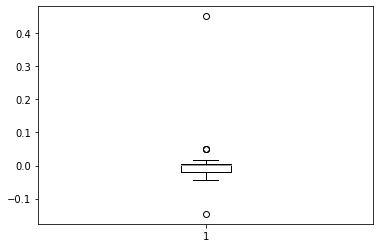

In [32]:
plt.boxplot(ccmf_2['lat_diff'][ccmf_2['lat_diff'].notna()])
plt.show()

In [33]:
(abs(ccmf_2['lat_diff']) > 0.05).value_counts()

False    1006
True        5
Name: lat_diff, dtype: int64

In [34]:
ccmf_2['long_diff'] = ccmf_2['longitude'] - ccmf_2['long']
ccmf_2['long_diff'].describe()

count    678.000000
mean       0.004826
std        0.084115
min       -0.726434
25%       -0.003935
50%        0.005312
75%        0.019692
max        1.950212
Name: long_diff, dtype: float64

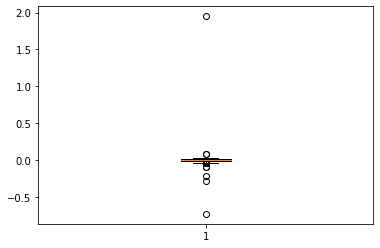

In [35]:
plt.boxplot(ccmf_2['long_diff'][ccmf_2['long_diff'].notna()])
plt.show()

In [36]:
(abs(ccmf_2['long_diff']) > 0.05).value_counts()

False    1003
True        8
Name: long_diff, dtype: int64

#### For latitude and longitude values from Geopy and Cities database, differences are minimal except for few values, but there are ~ 300 data points where there are no values in Cities database

In [37]:
ccmf_2['loc_city'].value_counts()

Ottawa              93
Toronto             92
Montreal            73
Vancouver           61
Edmonton            45
Calgary             43
Winnipeg            37
Halifax             31
Hamilton            18
Mississauga         16
Thunder Bay         13
Regina              12
Peterborough        11
London              10
Burnaby              9
Surrey               9
Saskatoon            8
Victoria             8
Windsor              8
St. John'S           7
Brampton             7
Waterloo             7
Coquitlam            7
Kamloops             7
Kelowna              6
Peel                 6
Richmond             5
Fort Mcmurray        5
York                 5
Kingston             5
                    ..
Simcoe North         1
Grande Prairie       1
Sault Ste. Marie     1
Innu Nation          1
Strathmore           1
Scarborough          1
Steveston            1
Cherry Brook         1
Kemptville           1
Penticton            1
Williams Lake        1
Peace River          1
Moncton    

In [38]:
ccmf_2['loc_city'].isna().sum()

141

In [39]:
ccmf_2['loc_city'].describe()

count        870
unique       166
top       Ottawa
freq          93
Name: loc_city, dtype: object